In [7]:
from src.PyTorch.HiggsDataset import HiggsDataset
from torch.utils.data import DataLoader
import keras
from src.Keras.PointCloudLayer import EdgeConvLayer, PointNetLayer, ChannelWiseGlobalAveragePooling

In [20]:
# Creating the trainning, validation and test set
higgs_trainning = HiggsDataset("../Data/HiggsTrainning.csv", "cpu")
higgs_validation = HiggsDataset("../Data/HiggsValidation.csv", "cpu")
higgs_test = HiggsDataset("../Data/HiggsTest.csv", "cpu")

# Exctracting the data from the torch tensors and converting to numpy arrays
data_loader_trainning = DataLoader(higgs_trainning, batch_size=len(higgs_trainning))
data_loader_validation = DataLoader(higgs_validation, batch_size=len(higgs_validation))
data_loader_test = DataLoader(higgs_test, batch_size=len(higgs_test))

torch_to_numpy = lambda torch_data: torch_data.numpy()
X_train, y_train = map(torch_to_numpy, next(iter(data_loader_trainning)))
X_val, y_val = map(torch_to_numpy, next(iter(data_loader_validation)))
X_test, y_test = map(torch_to_numpy, next(iter(data_loader_test)))

In [43]:
X_train.shape

(64000, 6, 7)

In [44]:
X_test[

array([[ 1.7424296 , -0.53378904, -0.14949863,  0.        ,  1.        ,
         0.        ,  0.        ],
       [ 0.25358033,  0.        , -0.16044012,  0.        ,  0.        ,
         1.        ,  0.        ],
       [ 0.28581452, -1.6636117 ,  1.1665666 ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.47364894,  0.18947813, -1.5992255 ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.86792064, -0.75351304,  1.5215446 ,  1.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.8933043 ,  0.64497733,  0.8982412 ,  1.        ,  0.        ,
         0.        ,  1.        ]], dtype=float32)

In [9]:
# Define the particle cloud model
def create_particle_cloud_model(input_tensor):
    mlp = keras.Sequential([
        keras.layers.InputLayer(shape=[14]),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU()
    ])
    # mlp_2 = keras.Sequential([
    #     keras.layers.InputLayer(shape=[64]),
    #     keras.layers.Dense(64, activation='relu'),
    #     keras.layers.Dense(64, activation='relu'),
    #     keras.layers.Dense(64, activation='relu')
    # ])
    x = EdgeConvLayer(mlp, 3, (1, 3))(input_tensor)
    # x = EdgeConvLayer(mlp_2, 4, (0, 33))(x)
    output = ChannelWiseGlobalAveragePooling()(x)
    return output

In [10]:
def create_point_net_model(input_tensor):
    mlp_3 = keras.Sequential([
        keras.layers.InputLayer(shape=[7]),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU()
    ])
    # mlp_4 = keras.Sequential([
    #     keras.layers.InputLayer(shape=[32]),
    #     keras.layers.Dense(64, activation='relu'),
    #     keras.layers.Dense(64, activation='relu'),
    #     keras.layers.Dense(64, activation='relu')
    # ])
    x = PointNetLayer(mlp_3)(input_tensor)
    # x = PointNetLayer(mlp_4)(x)
    output = ChannelWiseGlobalAveragePooling()(x)
    return output

In [11]:
input_layer = keras.layers.Input(shape=[6, 7])

# Get the outputs of particle cloud and point net models
particle_cloud_output = create_particle_cloud_model(input_layer)
point_net_output = create_point_net_model(input_layer)

# Concatenate the outputs
concatenated = keras.layers.Concatenate()([particle_cloud_output, point_net_output])

# Further processing
hidden_layer = keras.layers.Dense(64, activation='relu')(concatenated)
dropout = keras.layers.Dropout(rate=0.1)(hidden_layer)
hidden_layer = keras.layers.Dense(64, activation='relu')(dropout)
dropout = keras.layers.Dropout(rate=0.1)(hidden_layer)
final_layer = keras.layers.Dense(2, activation='softmax')(dropout)

# Create the final model
model = keras.Model(inputs=input_layer, outputs=final_layer)

# Print the model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 6, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_conv_layer_1   │ (None, 6, 32)     │      2,976 │ input_layer_3[0]… │
│ (EdgeConvLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ point_net_layer_1   │ (None, 6, 32)     │      2,752 │ input_layer_3[0]… │
│ (PointNetLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_wise_globa… │ (None, 32)        │          0 │ edge_conv_layer_… │
│ (ChannelWiseGlobal… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_wise_globa… │ (None, 32)        │          0 │ point_net_layer_… │
│ (ChannelWiseGlobal… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ channel_wise_glo… │
│ (Concatenate)       │                   │            │ channel_wise_glo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      4,160 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 2)         │        130 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,178 (55.38 KB)

 Trainable params: 13,794 (53.88 KB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
model.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5558 - loss: 0.6806 - val_accuracy: 0.5669 - val_loss: 0.6765
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6108 - loss: 0.6527 - val_accuracy: 0.6179 - val_loss: 0.6443
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6272 - loss: 0.6400 - val_accuracy: 0.6265 - val_loss: 0.6380
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6363 - loss: 0.6324 - val_accuracy: 0.6406 - val_loss: 0.6269
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6515 - loss: 0.6249 - val_accuracy: 0.6473 - val_loss: 0.6232
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6495 - loss: 0.6224 - val_accuracy: 0.6389 - val_loss: 0.6322
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6507 - loss: 0.6188 - val_accuracy: 0.6472 - val_loss: 0.6222
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6633 - loss: 0

In [46]:
# perfoming the prediction
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


In [14]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [15]:
print("Trainnig set:")
print(f"Recall for Top tagging: {recall_score(y_train[:, 0], y_train_pred[:, 0] >= 0.5):.4f}")
print(f"Precision for Top tagging: {precision_score(y_train[:, 0], y_train_pred[:, 0] > 0.5):.4f}")
print("Confusion Matrix")
print(confusion_matrix(y_train[:, 0], y_train_pred[:, 0] > 0.5, labels=[0, 1]))

Trainnig set:
Recall for Top tagging: 0.6473
Precision for Top tagging: 0.7069
Confusion Matrix
[[25682  8108]
 [10654 19556]]


In [16]:
print("Test set:")
print(f"Recall for Top tagging: {recall_score(y_val[:, 0], y_val_pred[:, 0] > 0.5):.2f}")
print(f"Precision for Top tagging: {precision_score(y_val[:, 0], y_val_pred[:, 0] > 0.5):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_val[:, 0], y_val_pred[:, 0] > 0.5, labels=[0, 1]))

Test set:
Recall for Top tagging: 0.61
Precision for Top tagging: 0.68
Confusion Matrix
[[6258 2184]
 [2910 4648]]


In [48]:
y_test_pred = model.predict(X_test[10:])
# print("Test set:")
# print(f"Recall for Top tagging: {recall_score(y_test[:, 0], y_test_pred[:, 0] > 0.5):.2f}")
# print(f"Precision for Top tagging: {precision_score(y_test[:, 0], y_test_pred[:, 0] > 0.5):.2f}")
# print("Confusion Matrix")
# print(confusion_matrix(y_test[:, 0], y_test_pred[:, 0] > 0.5, labels=[0, 1]))

591/625 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step

TypeError: Exception encountered when calling PointNetLayer.call().

[1munsupported operand type(s) for *: 'int' and 'NoneType'[0m

Arguments received by PointNetLayer.call():
  • events=tf.Tensor(shape=(None, 6, 7), dtype=float32)

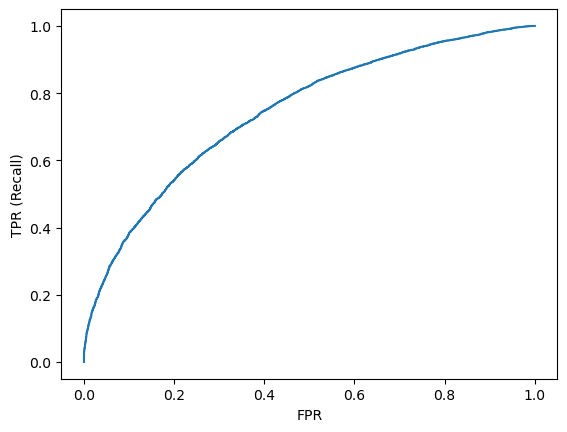

AUC: 0.7446


In [17]:
# roc curve for top tagging 
fpr, tpr, thresholds = roc_curve(y_val[:, 0], y_val_pred[:, 0])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()
print(f"AUC: {auc(fpr, tpr):.4f}")

<Axes: >

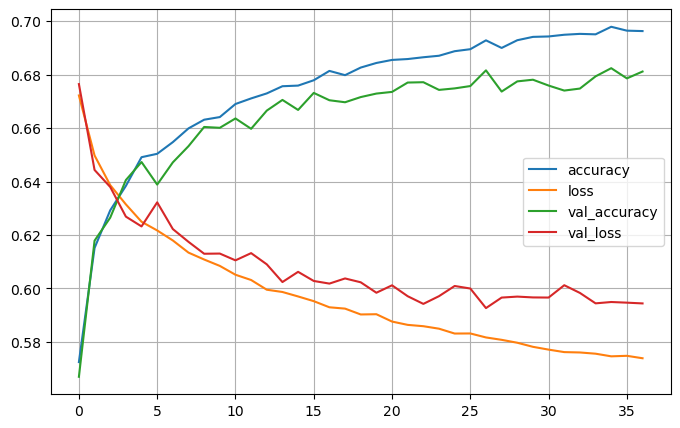

In [18]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca() # set the vertical range to [0-1] plt.show()